In [4]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from tapqir.models import Cosmos
from tapqir.utils.stats import ci_from_trace

In [5]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [19]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("seed"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        truth[data_path.name]["seed"] = data_path.name[4:]
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["seed"] = data_path.name[4:]

In [20]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df = truth_df.sort_values(by="seed")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr,seed
seed0,1.4,17.044015,0.145565,0.511275,0.361974,90.0,3000.0,150.0,2.408927,0
seed1,1.4,3.552921,0.135816,0.495435,0.379796,90.0,3000.0,150.0,5.276147,1
seed2,1.4,19.164651,0.181164,0.66973,0.323255,90.0,3000.0,150.0,2.271743,2
seed3,1.4,5.521328,0.090364,0.62572,0.226212,90.0,3000.0,150.0,4.232411,3
seed4,1.4,5.484914,0.013225,0.066515,0.360636,90.0,3000.0,150.0,4.246438,4
seed5,1.4,12.835132,0.097687,0.739899,0.56893,90.0,3000.0,150.0,2.775936,5
seed6,1.4,16.073462,0.162865,0.000452,0.465127,90.0,3000.0,150.0,2.48059,6
seed7,1.4,7.152823,0.01538,0.535882,0.346276,90.0,3000.0,150.0,3.718527,7


In [23]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="seed")
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,seed
seed0,2.438702,17.106777,17.106777,17.106777,0.139652,0.139652,0.139652,0.488797,0.488797,0.488797,...,0.930836,0.920228,2125.0,28.0,24.0,323.0,0.975099,0.940499,0.985806,0
seed1,5.431695,3.570417,3.570417,3.570417,0.142186,0.142186,0.142186,0.491212,0.491212,0.491212,...,0.971751,0.947658,2127.0,19.0,10.0,344.0,0.975934,0.940413,0.988109,1
seed2,2.313198,19.342373,19.342373,19.342373,0.188111,0.188111,0.188111,0.62341,0.62341,0.62341,...,0.930526,0.924686,1989.0,36.0,33.0,442.0,0.975955,0.933514,0.987533,2
seed3,4.361331,5.565966,5.565966,5.565966,0.088844,0.088844,0.088844,0.617835,0.617835,0.617835,...,0.903361,0.951327,2251.0,11.0,23.0,215.0,0.97981,0.912609,0.989897,3
seed4,4.190644,5.501768,5.501768,5.501768,0.013925,0.013925,0.013925,0.064443,0.064443,0.064443,...,0.971429,0.894737,2461.0,4.0,1.0,34.0,0.970302,0.900856,0.976455,4
seed5,2.856862,12.953563,12.953563,12.953563,0.092076,0.092076,0.092076,0.702604,0.702604,0.702604,...,0.879518,0.84556,2211.0,40.0,30.0,219.0,0.863916,0.628895,0.92139,5
seed6,2.441611,16.13397,16.13397,16.13397,0.173337,0.173337,0.173337,0.0,0.0,0.0,...,1.0,0.995181,2085.0,2.0,0.0,413.0,1.0,1.0,1.0,6
seed7,2.926029,7.194807,7.194807,7.194807,0.023662,0.023662,0.023662,0.538024,0.538024,0.538024,...,0.0,0.0,2455.0,2.0,43.0,0.0,0.070344,0.069268,0.17573,7


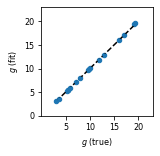

In [16]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["gain"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["gain"], fit_df["gain_mean"], s=20)
plt.errorbar(truth_df["gain"], fit_df["gain_mean"],
             yerr=(fit_df["gain_mean"] - fit_df["gain_low"], fit_df["gain_high"] - fit_df["gain_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)
plt.xlim(0, 23)
plt.ylim(0, 23)
plt.xticks([5, 10, 15, 20], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("$g$ (true)", fontsize=8)
plt.ylabel("$g$ (fit)", fontsize=8)
plt.savefig("/tmp/gain.svg")
plt.show()

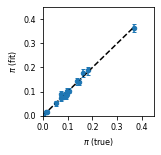

In [18]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["pi"].sort_values(), truth_df["pi"].sort_values(), "k--")
plt.scatter(truth_df["pi"], fit_df["pi_mean"], s=20)
plt.errorbar(truth_df["pi"], fit_df["pi_mean"],
             yerr=(fit_df["pi_mean"] - fit_df["pi_low"], fit_df["pi_high"] - fit_df["pi_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\pi$ (true)", fontsize=8)
plt.ylabel(r"$\pi$ (fit)", fontsize=8)
plt.savefig("/tmp/probsz.svg")
plt.show()

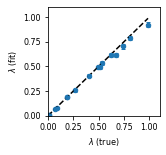

In [19]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["lamda"].sort_values(), truth_df["lamda"].sort_values(), "k--")
plt.scatter(truth_df["lamda"], fit_df["lamda_mean"], s=20)
plt.errorbar(truth_df["lamda"], fit_df["lamda_mean"],
             yerr=(fit_df["lamda_mean"] - fit_df["lamda_low"], fit_df["lamda_high"] - fit_df["lamda_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda$ (true)", fontsize=8)
plt.ylabel(r"$\lambda$ (fit)", fontsize=8)
plt.savefig("/tmp/ratej.svg")
plt.show()

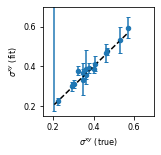

In [14]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["proximity"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["proximity"], fit_df["proximity_mean"], s=20)
plt.errorbar(truth_df["proximity"], fit_df["proximity_mean"],
             yerr=(fit_df["proximity_mean"] - fit_df["proximity_low"], fit_df["proximity_high"] - fit_df["proximity_mean"]),
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0.15, 0.7)
plt.ylim(0.15, 0.7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\sigma^{xy}$ (true)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fit)", fontsize=8)
plt.savefig("/tmp/proximity.svg")
plt.show()

In [4]:
from tapqir.distributions import AffineBeta

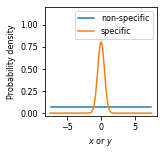

In [14]:
plt.figure(figsize=(2, 2))
x = torch.arange(-7.5, 7.5, 0.1)
d1 = AffineBeta(0, 2, -7.5, 7.5)
d2 = AffineBeta(0, 230, -7.5, 7.5)
plt.plot(x, d1.log_prob(x).exp(), label="non-specific")
plt.plot(x, d2.log_prob(x).exp(), label="specific")
plt.xlabel(r"$x$ or $y$", fontsize=8)
plt.ylabel("Probability density", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(-0.03, 1.2)
plt.legend(fontsize=8)
plt.savefig("/tmp/prior.svg")
plt.show()